In [1]:
import sys
sys.path.append('..')

import numpy as np
from matplotlib import pyplot as plt

from jax import grad,jit, jacfwd
from matplotlib import pyplot as plt
import jax.numpy as jnp

from functools import partial
%load_ext autoreload
%autoreload 2

In [77]:
def sep_func(ps):
    CoM = jnp.mean(ps,axis=0)
    A = ps-CoM
    return jnp.trace(A.T.dot(A))

3.771236
4.525483
5.4305797
6.5166955
7.820034
9.384041
11.26085
13.5130205
16.215624
19.45875
23.350498
28.020597
33.624718
40.349663
48.41959
58.10351
69.72421
83.66905
100.40287
120.483444
-11.445864 -24.891727
-49.783466 51.783463
65.229324 -24.891733


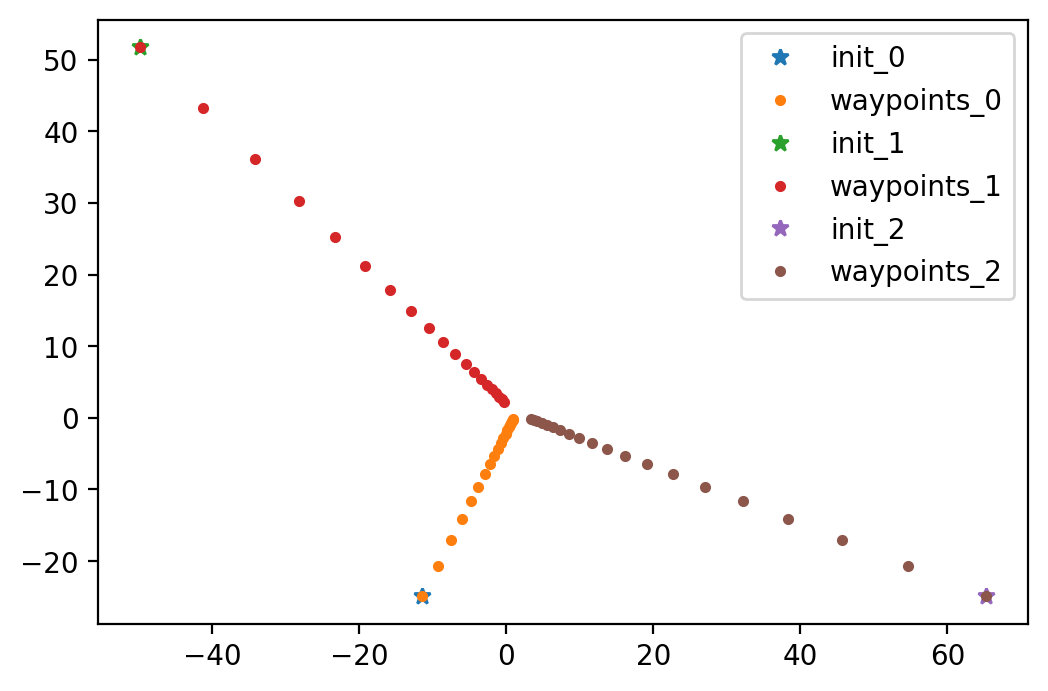

In [88]:

R=1
ps=np.array([[1.,0.],[0.,2.],[3.,0.]])
n_p = len(ps)
max_speed=0.22
dt = 1
n_steps = 300
p_trajs=[]

step_size = max_speed*dt
ps=ps.reshape(-1,2)

CoM= np.mean(ps,axis = 0)
f_dLdp = jacfwd(sep_func)
step_size = 0.1
p_trajs=[]
n_timesteps = 20
for i in range(n_timesteps):
        # Calculate the gradient
        grad=f_dLdp(ps)
        grad=grad.reshape(-1,2)
        grad_sizes=np.linalg.norm(grad,axis=1)
        grad_sizes[grad_sizes==0]=1 # Handle the case where the partial derivative is zero.

        update_steps=(grad.T/np.max(grad_sizes) * step_size).T # Calculate the update steps to be applied to ps

        candid_ps=ps+update_steps # Calculate the direct update 
        
        ps=candid_ps # Update ps.
        p_trajs.append(ps)
p_trajs = np.array(p_trajs)
fig = plt.figure(dpi=200)
for i in range(n_p):
    print(ps[i,0],ps[i,1])
    plt.plot(ps[i,0],ps[i,1],'*',label = 'init_{}'.format(i))
    plt.plot(p_trajs[:,i,0],p_trajs[:,i,1],'.',label= 'waypoints_{}'.format(i))
plt.legend()
plt.show()